# Star Selection

Contact author: Alex Broughton


In [1]:
! eups list -s | grep lsst_distrib
! eups list -s | grep cp_pipe
! eups list -s | grep ip_isr

lsst_distrib          g4213664e8e+da93b84f60 	current w_2023_37 setup
cp_pipe               g857a3418e4+f055a86da1 	current w_2023_37 setup
ip_isr                ga7ab7f6f60+80ebce256e 	current w_2023_37 setup


## Introduction

Check the star cuts made my different DRP-generated data tables. We want to maximimze the number of useable stars in each image.

## 1.0 Setup

First, I'll setup the space and define some utility functions that will be useful down the line.

We will learn how to access, reduce, and model the data using the data Butler attatched to USDF's $\texttt{/repo/embargo}$. The data is based on AuxTel data from the night of 2023-05-01+.

You can find the most recent data here:
$\texttt{https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-08-03}$




In [2]:
# Generic bunch of imports (not all of these are needed)
import os
import numpy as np
import glob
from astropy.io import fits
import pandas as pd
import pickle as pkl
import galsim
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker
from tqdm import tqdm
import gc
plt.rcParams.update({'font.size': 14})


In [12]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # Get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # Clear the figure
    plt.close(fig)  # Close the figure
    gc.collect()    # Call the garbage collector
    
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(8,8))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

def getAstropyWcs(image, verbose=False):
    """
    Get an astropy WCS object from an lsst.afw.image metadata WCS format
    
    Parameters
    ----------
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata

    Returns
    -------
    wcs: astropy.wcs.wcs.WCS
        Astropy WCS for the image object.
    """
    
    from astropy.wcs import WCS

    if verbose:
        print(image.getWcs())
    
    wcs_dict = dict()
    for val in image.getWcs().getFitsMetadata():
        wcs_dict[str(val)] = image.getWcs().getFitsMetadata()[str(val)]

    return WCS(wcs_dict)


def get2ndMomFromHsmResult(results):
    """
    Calculate second moments from HSM adative moment result
    derived by galsim HSM module (ShapeData object). 
    """
    e1 = results.observed_shape.e1
    e2 = results.observed_shape.e2
    sigma = results.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy


    
def getStars(data, img):
    image = img.getImage().getArray()
    results = np.full((len(data), 10), np.nan)
    for i in range(len(data)):
        star = data.iloc[i]
        result = np.full((1, 12), np.nan)

        y = star['x']
        x = star['y']

        s = int(70/2.)

        xmin = int(max(0,x-s))
        xmax = int(min(image.shape[0]-1, x+s+1))
        ymin = int(max(0,y-s))
        ymax = int(min(image.shape[1]-1, y+s+1))
        stamp = galsim.Image(image[xmin:xmax,ymin:ymax])

        try:
            res = galsim.hsm.FindAdaptiveMom(stamp)
            ixx,iyy,ixy = get2ndMomFromHsmResult(res)
            result = [ixx,iyy,ixy,np.max(image[xmin:xmax,ymin:ymax]),res.moments_sigma,res.moments_amp,x,y,res.observed_shape.e1,res.observed_shape.e2]
        except:
            continue
        
        results[i] = result
        
    return results

def getStarStampMax(data, img):
    image = img.getImage().getArray()
    results = []
    for i in range(len(data)):
        star = data.iloc[i]

        y = star['x']
        x = star['y']

        s = int(70/2.)

        xmin = int(max(0,x-s))
        xmax = int(min(image.shape[0]-1, x+s+1))
        ymin = int(max(0,y-s))
        ymax = int(min(image.shape[1]-1, y+s+1))
        stamp = galsim.Image(image[xmin:xmax,ymin:ymax])
        results.append(np.max(image[xmin:xmax,ymin:ymax]))
        
    return results
    
def writeNumpy2Parquet(data, filename, colnames):
    data = data[~np.isnan(data).any(axis=1)]
    
    data_dict = dict()
    for i,col in enumerate(colnames):
        data_dict[colnames[i]] = data[:,i]

    pd.DataFrame.from_dict(data_dict).to_parquet(filename, compression='gzip') 
    
PIXSCALE = 0.0956783 # arcsec/pixel


## 1.1 Accessing data

First we are going to setup a butler to repository where the LATISS data is ingested on USDF ($\texttt{/repo/embargo}$).

The DRP collections contain fully caliobrated images and tables of objects using the most up-to-date calibrations, and we will use those here.

Let's query all the collections that were processed with the most recent weekly release of the LSST Science Pipelines (w_2023_33):

In [4]:
repo = "/repo/embargo"
butler = Butler(repo)
registry = butler.registry

collections = []
for c in registry.queryCollections("u/laurenma/DM-40955_LATISS_PSF"):
    collections.append(c)
    print(c) 

u/laurenma/DM-40955_LATISS_PSF


This collection contains all science images since 5/01/2023.

Let's grab a smaller butler which contains a registry of data within just these collections. We will find all exposures that were imaged on or after 5/1/2023 in the SDSS *i*/*r*/*g* bands and have an associated table of calibrated stars.

There are 3 source catalogs that contain calibrated measurements that we might be interested in:

1. $\texttt{finalized_src_table}$: only includes the isolated stars used for computing PSF stats, etc ($\texttt{calib_psf_used == True}$). 

2. $\texttt{sourceTable_visit}$: contains all detected sources. All the relevant columns are in calibrated fluxes (units of nJy). 

3. $\texttt{icSrc}$: like (2) except the detection threshold is higher for that pass (and no deblending, I think), so there won’t be as many sources (and their measurements will only have very rough calibrations).

These collection are actually generated in reverse order $\texttt{icSrc}\rightarrow\texttt{sourceTable_visit}\rightarrow\texttt{finalized_src_table}\texttt{finalized_src_table}$ 

You can think of the outputs of $\texttt{finalized_src_table}$ as intermediate debugging catalogs. If you need something you can use them. But they should not be relied on and could change at any time…)




In [5]:
subbutler = Butler(repo,collections=collections)
subregistry = subbutler.registry
refs = np.sort(list(subregistry.queryDatasets(datasetType='sourceTable_visit', 
                                              collections=collections, 
                                              where="band='i' AND visit>=2023050100000")))

print(len(refs))

520


We now have a list of references which match specific images (visits in this case) and all their accompanying data products.

You can get any of the data types listed in the DRP pipeline associated with these visits. 

In [6]:
# subbutler = Butler(repo,collections=collections)
# subregistry = subbutler.registry
# for dtype in subregistry.queryDatasetTypes():
#     try:
#         datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
#         print(len(datasetRefs), dtype )
#     except:
#         print("Error", dtype )

If you want the processed image, you can query postISRCCD or calexp. 
$\texttt{postISRCCD}$ is an image that has been run through ISR but has not been calibrated astrometrically or photometrically or with a PSF model.
It is a temporary intermediate object that will not be part of a release. In the future, $\texttt{calexps}$ will be called $\texttt{pvis}$, or “processed visit images”.
These will have final-final calibrations applied (the calexp has early calibrations). To get $\texttt{calexps}$, you must also pass the detector argument (there is only one sensor on AuxTel and its detector number is 0). If you want a $\texttt{postISRCCD}$, you will also need to supply an exposure number, which in this case is the same as the visit number since we are only taking one exposure/vist.

## 2.0 Example (Single Visit)

In [15]:
# idx = 500 is a high stellar density field
# idx = 1 is a low stellar density field
idx = 500
refs[idx].dataId

{instrument: 'LATISS', visit: 2023082900449, ...}

In [16]:
sources = subbutler.get('sourceTable_visit', 
                        dataId = refs[idx].dataId,
                        detector=0,
                        collections=collections)
#for c in sources.columns:
#    print(c)

In [17]:
image = subbutler.get('calexp', 
                      dataId = refs[idx].dataId,
                      detector=0,
                      collections=collections)

#print(image.getMetadata())

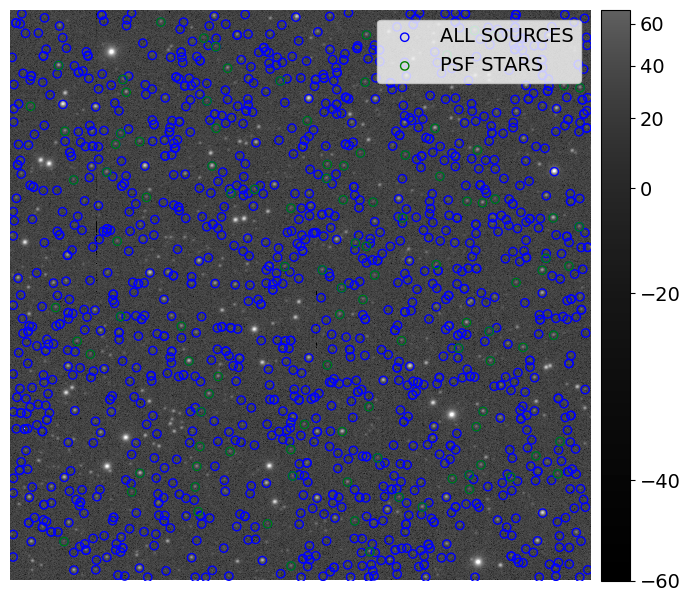

In [20]:
display(image)

psfstars = (sources['calib_psf_used'] == True)
extended = (sources['extendedness_flag'] == True)
blended = (sources['blendedness_flag'] == True)
edge = (sources['pixelFlags_edge'] == True)
badpix = (sources['pixelFlags_bad'] == True)

plt.scatter(sources['x'], sources['y'], marker="o", color="blue", facecolor="None", label="ALL SOURCES")
plt.scatter(sources['x'][psfstars], sources['y'][psfstars], marker="o", color="green", facecolor="None", label="PSF STARS")
plt.legend(loc=1)

Notice that the sources are contaminated by bad columns, cosmic rays, etc.

## 2.1 Data Wrangling

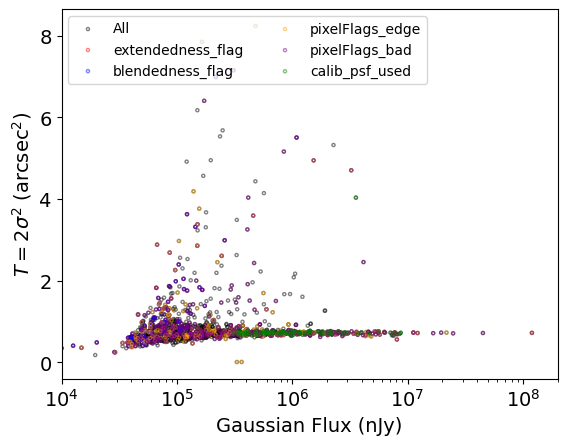

In [49]:
T = (sources['ixx'] + sources['iyy']) * PIXSCALE**2

plt.scatter(sources['gaussianFlux'], T, color="k", marker="o",facecolor="None",s=5, alpha=0.5,label="All")
plt.scatter(sources['gaussianFlux'][extended], T[extended], color="red", marker="o",facecolor="None",s=5, alpha=0.5, label="extendedness_flag")
plt.scatter(sources['gaussianFlux'][blended], T[blended], color="blue", marker="o",facecolor="None",s=5, alpha=0.5, label="blendedness_flag")
plt.scatter(sources['gaussianFlux'][edge], T[edge], color="orange", marker="o",facecolor="None",s=5, alpha=0.5, label="pixelFlags_edge")
plt.scatter(sources['gaussianFlux'][badpix], T[badpix], color="purple", marker="o",facecolor="None",s=5, alpha=0.5, label="pixelFlags_bad")
plt.scatter(sources['gaussianFlux'][psfstars], T[psfstars], color="green", marker="o",facecolor="None",s=5, alpha=0.5, label="calib_psf_used")

plt.ylabel("$T = 2\sigma^{2}$" + " (arcsec$^{2}$)")
plt.xlabel("Gaussian Flux (nJy)")
plt.xscale('log')
plt.xlim(1e4,2e8)
plt.legend(ncol=2,loc=2,fontsize=10)

## 2.1 Extend the number of good sources

A detailed list of flags with descriptions can be found here:
    https://dm.lsst.org/sdm_schemas/browser/dp02.html

In [8]:
good_dict = \
{'blendedness_flag': False,
 'blendedness_flag_noCentroid': False,
 'blendedness_flag_noShape': False,
 'extendedness_flag': False,
 'jacobian_flag': False,
 'localBackground_flag': False,
 'localBackground_flag_noGoodPixels': False,
 'localBackground_flag_noPsf': False,
 'pixelFlags_bad': False,
 'pixelFlags_cr': False,
 'pixelFlags_crCenter': False,
 #'pixelFlags_edge': False,
 'pixelFlags_interpolated': False,
 'pixelFlags_interpolatedCenter': False,
 'pixelFlags_offimage': False,
 'pixelFlags_saturated': False,
 'pixelFlags_saturatedCenter': False,
 'pixelFlags_suspect': False,
 'pixelFlags_suspectCenter': False,
 'psfFlux_flag': False,
 'psfFlux_flag_apCorr': False,
 'psfFlux_flag_edge': False,
 'psfFlux_flag_noGoodPixels': False,
 'gaussianFlux_flag': False,
 'centroid_flag_almostNoSecondDerivative': False,
 'centroid_flag_badError': False,
 #'centroid_flag_edge': False,
 'centroid_flag_noSecondDerivative': False,
 'centroid_flag_notAtMaximum': False,
 'centroid_flag_resetToPeak': False,
 # 'calib_astrometry_used': True,
 #'calib_detected': True,
 # 'calib_photometry_reserved': False,
 # 'calib_photometry_used': True,
 # 'calib_psf_candidate': True,
 # 'calib_psf_reserved': False,
 # 'calib_psf_used': True,
 'variance_flag': True,
 'variance_flag_emptyFootprint': True,
 #'deblend_hasStrayFlux': False,
 #'deblend_masked': False,
 #'deblend_parentTooBig': False,
 #'deblend_patchedTemplate': False,
 #'deblend_rampedTemplate': False,
 #'deblend_skipped': False,
 #'deblend_tooManyPeaks': False,
 'hsmPsfMoments_flag': False,
 'hsmPsfMoments_flag_no_pixels': False,
 'hsmPsfMoments_flag_not_contained': False,
 'hsmPsfMoments_flag_parent_source': False,
 'iDebiasedPSF_flag': False,
 'iDebiasedPSF_flag_no_pixels': False,
 'iDebiasedPSF_flag_not_contained': False,
 'iDebiasedPSF_flag_galsim': False,
 'iDebiasedPSF_flag_edge': False}



In [ ]:
good = np.ones_like(sources['calib_psf_used'], dtype=bool)
for i, key in enumerate(good_dict.keys()):
    mask = (sources[key].to_numpy() == good_dict[key])
    if i == 0:
        good = mask
    good = np.logical_and(good,mask)
#good = np.logical_or(good,sources['calib_psf_used'])

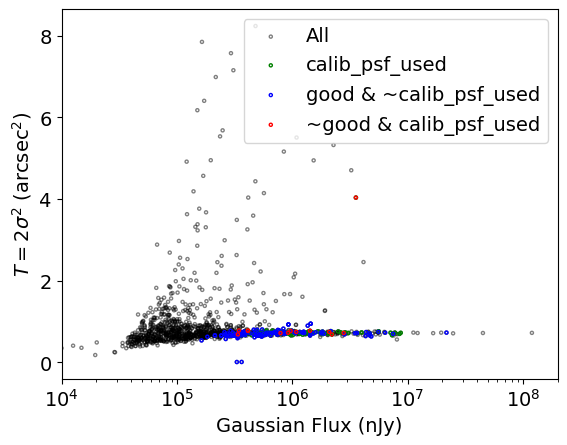

In [52]:
new = good & ~psfstars
suspect = (~good * psfstars)

plt.scatter(sources['gaussianFlux'], T, color="k", marker="o",facecolor="None", s=5, alpha=0.5, label="All")
plt.scatter(sources['gaussianFlux'][psfstars], T[psfstars], color="green", marker="o",facecolor="None",s=5, label="calib_psf_used")
plt.scatter(sources['gaussianFlux'][new], T[new], color="blue", marker="o",facecolor="None",s=5, label="good & ~calib_psf_used")
plt.scatter(sources['gaussianFlux'][suspect], T[suspect], color="red", marker="o",facecolor="None",s=5, label="~good & calib_psf_used")

plt.ylabel("$T = 2\sigma^{2}$" + " (arcsec$^{2}$)")
plt.xlabel("Gaussian Flux (nJy)")
plt.xscale('log')
plt.xlim(1e4,2e8)
plt.legend()

Check the flags for the suspect ones:

In [40]:
suspect = (~good * sources['calib_psf_used'])

for c in sources.columns:
    try:
        if sources[suspect].iloc[0][c].dtype==bool:
            print(c, sources[suspect].iloc[1][c])
    except:
        continue

ap03Flux_flag False
ap06Flux_flag False
ap09Flux_flag False
ap12Flux_flag False
ap17Flux_flag False
ap25Flux_flag False
ap35Flux_flag False
ap50Flux_flag False
ap70Flux_flag False
localPhotoCalib_flag False
localWcs_flag False
blendedness_flag False
blendedness_flag_noCentroid False
blendedness_flag_noShape False
apFlux_12_0_flag False
apFlux_12_0_flag_apertureTruncated False
apFlux_12_0_flag_sincCoeffsTruncated False
apFlux_17_0_flag False
apFlux_35_0_flag False
apFlux_50_0_flag False
extendedness_flag False
jacobian_flag False
localBackground_flag False
localBackground_flag_noGoodPixels False
localBackground_flag_noPsf False
pixelFlags_bad False
pixelFlags_cr False
pixelFlags_crCenter False
pixelFlags_edge False
pixelFlags_interpolated False
pixelFlags_interpolatedCenter False
pixelFlags_offimage False
pixelFlags_saturated False
pixelFlags_saturatedCenter False
pixelFlags_suspect False
pixelFlags_suspectCenter False
psfFlux_flag False
psfFlux_flag_apCorr False
psfFlux_flag_edge False


<br> To get the good mask, which has star-like objects at lower flux, we need to loosen some of the flags and tighten others in order to avoid strays. This clips out some of the $\texttt{calib_psf_used == True}$ stars. So we will join the two masks:



In [53]:
good = np.logical_or(good,sources['calib_psf_used'])

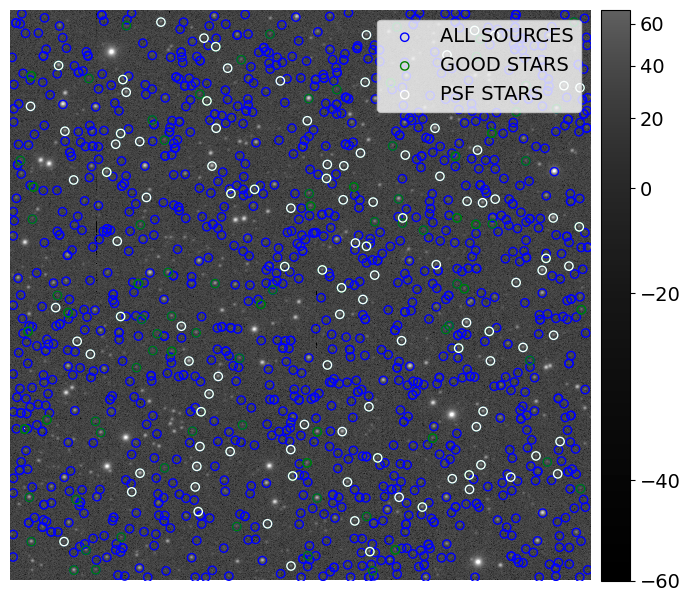

In [54]:
display(image)

plt.scatter(sources['x'], sources['y'], marker="o", color="blue", facecolor="None", label="ALL SOURCES")
plt.scatter(sources['x'][good], sources['y'][good], marker="o", color="green", facecolor="None", label="GOOD STARS")
plt.scatter(sources['x'][psfstars], sources['y'][psfstars], marker="o", color="white", facecolor="None", label="PSF STARS")

plt.legend(loc=1)


## 3.0 Extended datasets (multi-band)

In [37]:
def getGoodStars(sources):
    good = np.ones_like(sources['calib_psf_used'], dtype=bool)
    for i, key in enumerate(good_dict.keys()):
        mask = (sources[key].to_numpy() == good_dict[key])
        if i == 0:
            good = mask
        good = np.logical_and(good,mask)
    good = np.logical_or(good,sources['calib_psf_used'])
    
    return sources[good]

In [66]:
%%time
refs = list(subregistry.queryDatasets(datasetType='sourceTable_visit', collections=collections, where="band='i' AND visit>=2023050100000")) 
data_list_i = []
for ref in tqdm(refs):
    data = subbutler.get('sourceTable_visit', dataId = ref.dataId, collections=collections)
    data_list_i.append(len(getGoodStars(data)))

refs = list(subregistry.queryDatasets(datasetType='sourceTable_visit', collections=collections, where="band='r' AND visit>=2023050100000")) 
data_list_r = []
for ref in tqdm(refs):
    data = subbutler.get('sourceTable_visit', dataId = ref.dataId, collections=collections)
    data_list_r.append(len(getGoodStars(data)))

refs = list(subregistry.queryDatasets(datasetType='sourceTable_visit', collections=collections, where="band='g' AND visit>=2023050100000")) 
data_list_g = []
for ref in tqdm(refs):
    data = subbutler.get('sourceTable_visit', dataId = ref.dataId, collections=collections)
    data_list_g.append(len(getGoodStars(data)))

100%|██████████| 489/489 [00:44<00:00, 10.92it/s]

CPU times: user 31.7 s, sys: 2.87 s, total: 34.5 s
Wall time: 2min 17s


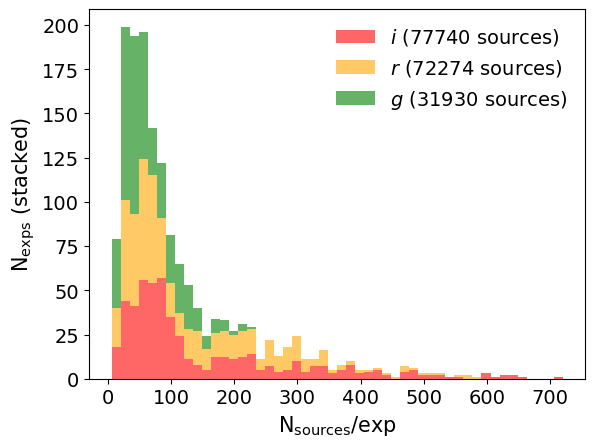

In [67]:
plt.figure()
_ = plt.hist([data_list_i,data_list_r,data_list_g], 
             stacked=True, bins=50, 
             color=['r','orange','g'], 
             label=[f'$i$ ({np.sum(data_list_i)} sources)',
                    f'$r$ ({np.sum(data_list_r)} sources)',
                    f'$g$ ({np.sum(data_list_g)} sources)'], 
             alpha=0.6)

plt.ylabel("$\mathrm{N_{exps}}$ (stacked)", fontsize=15)
plt.xlabel("$\mathrm{N_{sources}}$/exp", fontsize=15)
plt.legend(frameon=False)


In [68]:
np.sum([np.sum(data_list_i),np.sum(data_list_r),np.sum(data_list_g)])

181944

### 3.1  Compute your own metrics/star

In [13]:
%%time

full_data_i = pd.DataFrame()
refs = list(subregistry.queryDatasets(datasetType='sourceTable_visit', collections=collections, where="band='i' AND visit>=2023050100000")) 
for ref in tqdm(refs):
    data = subbutler.get('sourceTable_visit', dataId = ref.dataId, collections=collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=collections)
    fMaxs = getStarStampMax(data, image)
    
    mjds = [image.getMetadata()['MJD']]*len(data)
    visits = [ref.dataId['visit']]*len(data)
    
    data["MJD"] = mjds
    data["visit"] = visits
    data["fMax"] = fMaxs
    
    full_data_i = pd.concat([full_data_i, data])

full_data_i.to_parquet(f"./df_stars_iband.parquet.gzip", compression='gzip')
del full_data_i

100%|██████████| 520/520 [10:49<00:00,  1.25s/it]


CPU times: user 7min 53s, sys: 1min 39s, total: 9min 33s
Wall time: 11min 1s


In [15]:
%%time

full_data_r = pd.DataFrame()
refs = list(subregistry.queryDatasets(datasetType='sourceTable_visit', collections=collections, where="band='r' AND visit>=2023050100000")) 
for ref in tqdm(refs):
    data = subbutler.get('sourceTable_visit', dataId = ref.dataId, collections=collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=collections)
    fMaxs = getStarStampMax(data, image)
    
    mjds = [image.getMetadata()['MJD']]*len(data)
    visits = [ref.dataId['visit']]*len(data)
    
    data["MJD"] = mjds
    data["visit"] = visits
    data["fMax"] = fMaxs
    
    full_data_r = pd.concat([full_data_r, data])

full_data_r.to_parquet(f"./df_stars_rband.parquet.gzip", compression='gzip')
del full_data_r

100%|██████████| 547/547 [11:02<00:00,  1.21s/it]


CPU times: user 8min 7s, sys: 1min 43s, total: 9min 51s
Wall time: 11min 13s


In [16]:
%%time

full_data_g = pd.DataFrame()
refs = list(subregistry.queryDatasets(datasetType='sourceTable_visit', collections=collections, where="band='g' AND visit>=2023050100000")) 
for ref in tqdm(refs):
    data = subbutler.get('sourceTable_visit', dataId = ref.dataId, collections=collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=collections)
    fMaxs = getStarStampMax(data, image)
    
    mjds = [image.getMetadata()['MJD']]*len(data)
    visits = [ref.dataId['visit']]*len(data)
    
    data["MJD"] = mjds
    data["visit"] = visits
    data["fMax"] = fMaxs
    
    full_data_g = pd.concat([full_data_g, data])
    
full_data_g.to_parquet(f"./df_stars_gband.parquet.gzip", compression='gzip')
del full_data_g



100%|██████████| 489/489 [08:41<00:00,  1.07s/it]


CPU times: user 6min 52s, sys: 1min 33s, total: 8min 26s
Wall time: 8min 48s


In [87]:
full_data_i = pd.read_parquet("./df_stars_iband.parquet.gzip") #.to_numpy()
full_data_r = pd.read_parquet("./df_stars_rband.parquet.gzip") #.to_numpy()
full_data_g = pd.read_parquet("./df_stars_gband.parquet.gzip") #.to_numpy()

In [88]:
stars_i = getGoodStars(full_data_i)
del full_data_i
stars_r = getGoodStars(full_data_r)
del full_data_r
stars_g = getGoodStars(full_data_g)
del full_data_g

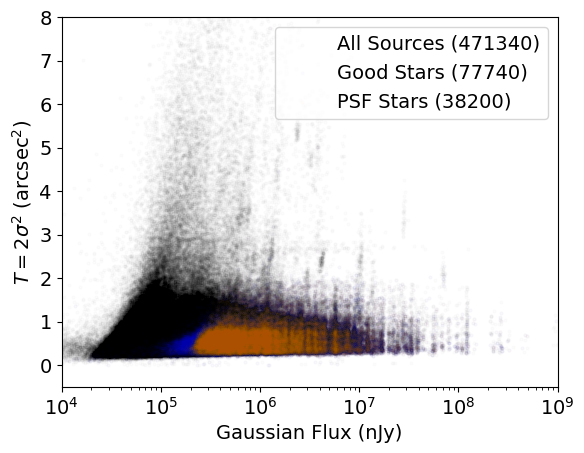

In [75]:
T_stars = (stars_i['ixx'] + stars_i['iyy']) * PIXSCALE**2
T_full = (full_data_i['ixx'] + full_data_i['iyy']) * PIXSCALE**2

psf_stars=full_data_i['calib_psf_used']

plt.scatter(full_data_i['gaussianFlux'], T_full, color="k", marker="o",s=5, alpha=0.01,label=f"All Sources ({len(T_full)})")
plt.scatter(stars_i['gaussianFlux'], T_stars, color="b", marker="o",s=5, alpha=0.01,label=f"Good Stars ({len(T_stars)})")
plt.scatter(full_data_i['gaussianFlux'][psf_stars], T_full[psf_stars], color="orange", marker="o",s=5, alpha=0.01,label=f"PSF Stars ({len(T_full[psf_stars])})")

plt.ylabel("$T = 2\sigma^{2}$" + " (arcsec$^{2}$)")
plt.xlabel("Gaussian Flux (nJy)")
plt.xscale('log')
plt.xlim(1e4,1e9)
plt.ylim(-0.5,8)
#plt.yscale('log')
plt.legend(ncol=1,loc=1)

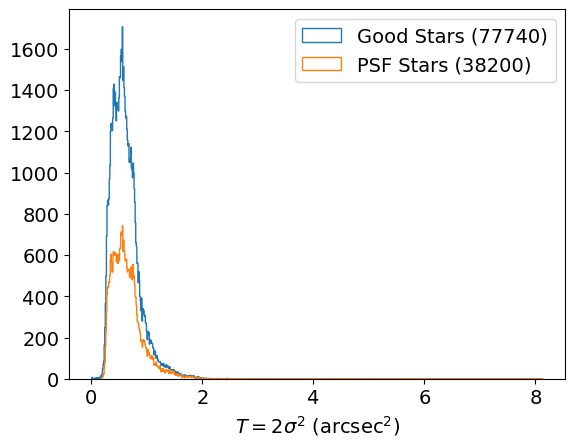

In [78]:
_=plt.hist(T_stars,bins=800,histtype='step',label=f"Good Stars ({len(T_stars)})")
_=plt.hist(T_full[psf_stars], bins=800,histtype='step',label=f"PSF Stars ({len(T_full[psf_stars])})")
plt.xlabel("$T = 2\sigma^{2}$" + " (arcsec$^{2}$)")
plt.legend()